In this Article we will try to implement an Encoder-Decoder Transformer from scratch in pytorch
We will use some special refernces which will navigate us in the right direction:

https://nlp.seas.harvard.edu/annotated-transformer/

https://adeveloperdiary.com/data-science/deep-learning/nlp/coding-transformer-model-from-scratch-using-pytorch-part-1/

https://adeveloperdiary.com/data-science/deep-learning/nlp/coding-transformer-model-from-scratch-using-pytorch-part-2/b

https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

https://www.kaggle.com/code/lusfernandotorres/transformer-from-scratch-with-pytorch

https://peterbloem.nl/blog/transformers

This notebook can be directly attributed to 

https://adeveloperdiary.com/data-science/deep-learning/nlp/coding-transformer-model-from-scratch-using-pytorch-part-1/

https://adeveloperdiary.com/data-science/deep-learning/nlp/coding-transformer-model-from-scratch-using-pytorch-part-2/

The go to Image in all cases:

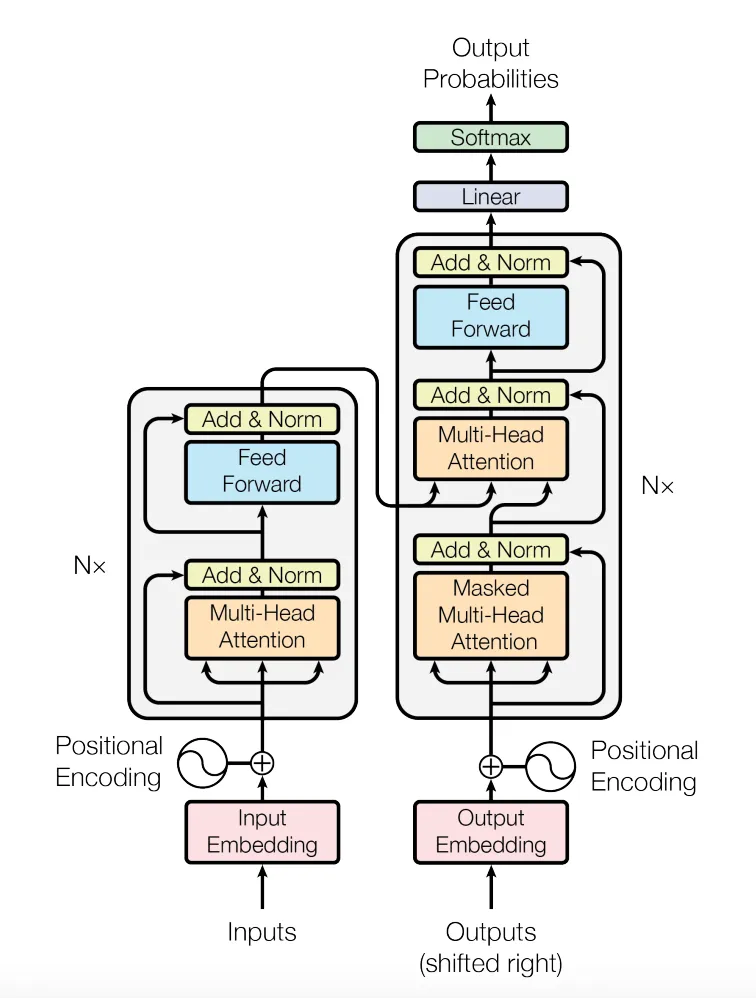

In [ ]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
# import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as plt

## Input Embedding 
- Instead of created two separate embedding layers, we will create one IOEmbeddingBlock which will be used for both Input embedding and output embeddings for both encoder and decoder layer

In [2]:
# Part of Actual Transformer Model
class IOEmbedding(nn.Module):
    """
    This class is used to create the embedding layer for the input and output tokens.
    The embedding layer is a simple nn.Embedding layer with the input size as the vocab size and the output size as the d_model.
    The output of the embedding layer is then multiplied by sqrt(d_model) as per the transformer paper.

    Args:
    d_model : int : The dimension of the model
    vocab_size : int : The size of the vocabulary

    Returns:
    op : tensor : The output of the embedding layer
    """

    def __init__(self, d_model, vocab_size):
        super(IOEmbedding, self).__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding_layer = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        op = self.embedding_layer(x) * math.sqrt(self.d_model)
        return op

## Positional Embedding
-  the Transformer architecture introduces multi-head attention to enhance speed through parallelism, sacrificing positional details. Consequently, the authors of the paper made a deliberate effort to preserve position information by directly incorporating it into the embedding layer through addition (sum). This technique of preserving word order is referred to as Positional Encoding.
-  If the length of the sentence is given by seq_len and the embedding dimension is then the Positional Encoding is also a 2D matrix (Same dimension as the embedding)
  
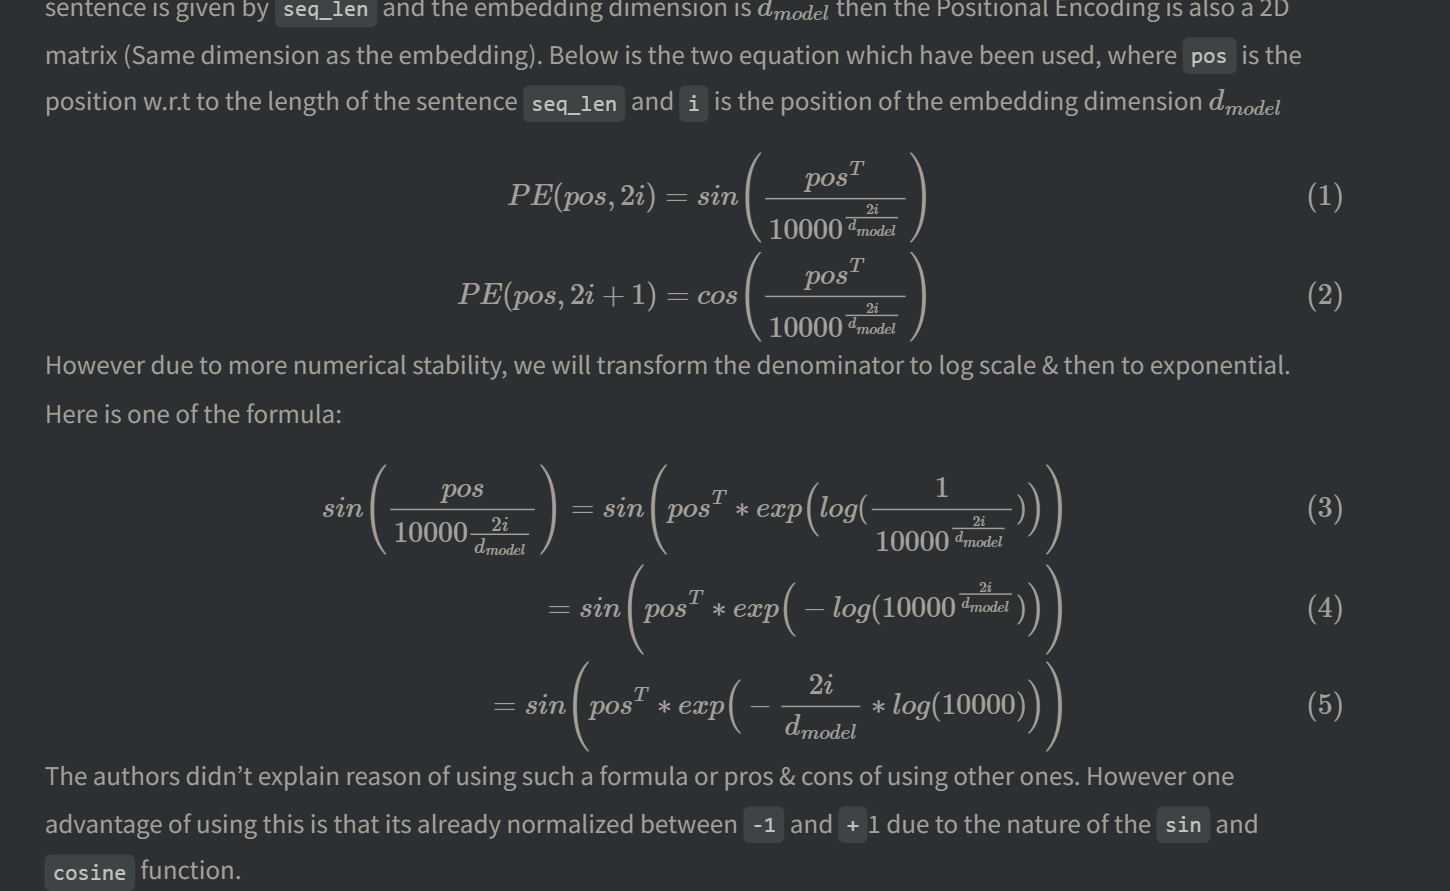

* The dim of positional embeddings should be same as that of the embedding model , so if we have a vector of [seq_len,1] and another vector of [1,d_model] where seq_len representsthe batch of tokens passed and d_model respresents the dim for embedding then [seq_len, 1] * [1, d_model] = [seq_len, d_model]
* With a 10-dimensional embedding, we can simplify calculations by creating a vector to handle both sine and cosine functions simultaneously, ensuring it has half the length of `d_model` and using identical values for both functions.
* Each value in postional encoding matrix (seq_len, emb_dim) will be filled by sin/cosine (pos^T * exp( (-2i*log(10000)/d_model ) )

In [3]:
# Demo of how positional Embeddings work
d_model = 10
seq_len = 20
# postional vector
pos = torch.arange(0, seq_len).unsqueeze(1)  # we need in the form of (seq_len,1)
# embedding matrix
two_index = torch.arange(
    0, d_model, 2
).float()  # index get shared by alternative postions between sin and cosine

print(pos.shape)
print(two_index.shape)

# positional encoding matrix
positional_encoding = torch.zeros(
    seq_len, d_model
)  # this is the matrix where we store alternate sin and cosine values
print(positional_encoding.shape)

# sin and cosine values
exponential_term = torch.exp(
    two_index * -(math.log(10000.0) / d_model)
)  # this is the exponential term in the positional encoding
print(exponential_term.shape)

torch.Size([20, 1])
torch.Size([5])
torch.Size([20, 10])
torch.Size([5])


In [4]:
# fill the 0::2 with sin terms and 1::2 with cosine terms
positional_encoding[:, 0::2] = torch.sin(pos.float() * exponential_term)
positional_encoding[:, 1::2] = torch.cos(pos.float() * exponential_term)

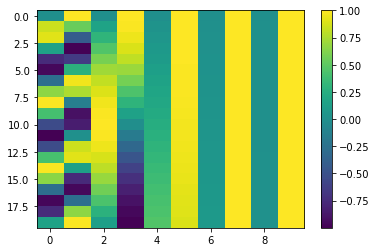

In [5]:
plt.imshow(positional_encoding, aspect="auto")
plt.colorbar()
plt.show()

In [6]:
def create_positional_embeddings(seq_len, d_model):
    """
    This function is used to create the positional embeddings for the input sequence.
    The positional embeddings are created using the formulae mentioned in the transformer paper.
    The positional embeddings are then returned.

    Args:
    seq_len : int : The length of the sequence
    d_model : int : The dimension of the model

    Returns:
    positional_encoding : tensor : The positional embeddings for the input sequence
    """
    pos = torch.arange(0, seq_len).unsqueeze(1)
    two_index = torch.arange(0, d_model, 2).float()
    exponential_term = torch.exp(two_index * -(math.log(10000.0) / d_model))
    positional_encoding = torch.zeros(seq_len, d_model)
    positional_encoding[:, 0::2] = torch.sin(pos.float() * exponential_term)
    positional_encoding[:, 1::2] = torch.cos(pos.float() * exponential_term)
    return positional_encoding

We create a `PositionalEncoding` class extending PyTorch’s `nn.Module` to modularize code, even though positional encoding doesn't involve learning. The `__init__()` function sets up dropout and registers the positional encoding in a buffer to ensure it is saved with the model. This buffer allows us to reference positional encoding in the `forward()` function without directly defining it under `self` in the `__init__()`.

In [7]:
# Part of Actual Transformer Model
class PositionalEncodingBlock(nn.Module):
    """
    This class is used to add the positional encoding to the input sequence.
    The positional encoding is added to the input sequence by simply adding the positional encoding to the input sequence.
    The positional encoding is a tensor of shape (1, seq_len, d_model) which is added to the input sequence.

    Args:
    d_model : int : The dimension of the model
    seq_len : int : The length of the sequence

    Returns:
    x : tensor : The output of the positional encoding block
    """

    def __init__(self, d_model, seq_len):
        super(PositionalEncodingBlock, self).__init__()
        positional_encoding = create_positional_embeddings(seq_len, d_model)
        # add batch information by introducing a new dimension
        positional_encoding = positional_encoding.unsqueeze(0)
        # Use register buffer to save positional_encoding when the model is exported in disk.
        self.register_buffer("positional_encoding", positional_encoding)

    def forward(self, x):
        # add positional encoding to the input which is ouput of the embedding layer
        x = x + self.positional_encoding[:, : x.size(1)].requires_grad_(False)
        return x

## Attention Block
* The paper uses Masked-Multi-Head-Self-Attention, which involves three matrices: Q (Query), K (Key), and V (Value). We calculate self-attention using the scaled dot product attention formula. Q, K, and V are learned parameters, and we can use `nn.Linear()` with `bias=False` to implement this. 

* Q combines with every K to influence output weights, producing a [batch, seq_len, seq_len] matrix. V combines with the normalized scores from QK to extract information, with a scaling factor to prevent dimension size influence. In implementation, transposing K allows matrix multiplication with Q, resulting in scores of dimension [batch, seq_len, seq_len].

Q -> A query matrix of shape (batch_size, seq_len, d_k)\
K -> A key matrix of shape (batch_size, seq_len, d_k)\
V -> A value matrix of shape (batch_size, seq_len, d_v)

Q*K^T -> (batch_size, seq_len, seq_len)\
Scaling -> (Q*K^T)/sqrt(d_k) -> (batch_size, seq_len, seq_len)\
Softmax -> Softmax((Q*K^T)/sqrt(d_k)) -> (batch_size, seq_len, seq_len)\
Softmax(Q*K^T)*V -> (batch_size, seq_len, seq_len)*(batch_size, seq_len, d_v) -> (batch_size, seq_len, d_v)

In [8]:
d_k=6
seq_len=3

q=torch.rand(1,seq_len,d_k)					
k=torch.rand(1,seq_len,d_k)
v=torch.rand(1,seq_len,d_k)
print(q.shape)

torch.Size([1, 3, 6])


In [9]:
# scoring of qk
qk = q @ k.transpose(-2, -1)
print(qk.shape)
# scaling
scaled_qk = qk / math.sqrt(d_k)
print(scaled_qk.shape)

# softmax
scored = F.softmax(scaled_qk, dim=-1)
print(scored.shape)

# final value matrix with attention scores
final_scores = scored @ v
print(final_scores.shape)

# nn.Softmax(dim=-1)(scaled_qk)
# scaled_qk.softmax(dim=-1)

torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 3])
torch.Size([1, 3, 6])


In [10]:
def attention(q, k, v, d_k):
    """
    This function is used to calculate the attention scores for the input query, key and value.
    The attention scores are calculated using the formulae mentioned in the transformer paper.
    The attention scores are then returned.

    Args:
    q : tensor : The query tensor
    k : tensor : The key tensor
    v : tensor : The value tensor
    d_k : int : The dimension of the heads

    Returns:
    final_scores : tensor : The attention scores for the input query, key and value
    """
    d_k = q.size(-1)
    qk = q @ k.transpose(-2, -1)
    scaled_qk = qk / math.sqrt(d_k)
    scored = F.softmax(scaled_qk, dim=-1)
    final_scores = scored @ v
    return final_scores

In [11]:
# attention(q, k, v, d_k)

Now there are two variations of Self-Attention we need to talk about and what is d_k and how it is related to the number of heads and d_modelm

* Multi-Head Self Attention (Used in both Encoder & Decoder)
* Masked Multi-Head Self Attention (Used in Decoder)

## MuLTi-Head Self Attention:
* What is multi-head self attention - Multi-head self attention is a mechanism that allows the model to focus on different parts of the input sequence. The input sequence is divided into multiple heads and each head is used to calculate the attention scores. The attention scores are then concatenated and passed through a linear layer to get the final output.
* Researchers found that splitting the embedding dimension (`d_model`) and calculating self-attention for each part separately helps the model learn better. For `d_model=6`, we split it into `d_k=3` with `head=2`, indicating two splits in the embedding dimension.
* In Multi-Head Self Attention, after concatenating heads, we apply another linear transformation with a weight matrix to adjust the significance of attention scores, unique to this method, not in vanilla self-attention.

In [12]:
d_model=10
seq_len=3
heads=2

In [13]:
d_k = d_model // heads
print(d_k)
# we initialize the weights for the query, key and value layers with same of the d_model
q = torch.rand(1, seq_len, d_model)
k = torch.rand(1, seq_len, d_model)
v = torch.rand(1, seq_len, d_model)
print(q.shape)

5
torch.Size([1, 3, 10])


So the idea is to convert (batch, seq_len, d_model) --> (batch, seq_len, head, d_k) --> (batch, head, seq_len, d_k), so theinput would be batches of heads of sequences of embeddings

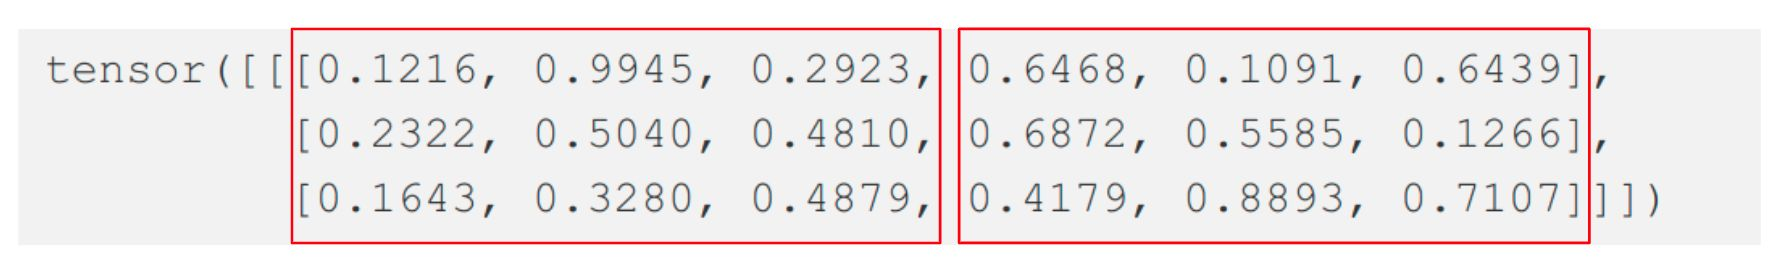

In [14]:
# breaking to into batches of multiheaded sequence of vectors
q = q.view(q.shape[0], q.shape[1], heads, d_k).transpose(2, 1)
k = k.view(k.shape[0], k.shape[1], heads, d_k).transpose(2, 1)
v = v.view(v.shape[0], v.shape[1], heads, d_k).transpose(2, 1)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([1, 2, 3, 5])
torch.Size([1, 2, 3, 5])
torch.Size([1, 2, 3, 5])


In [15]:
# Only difference is the attention scores are for each of the heads.
attention_scores = attention(q, k, v, d_k)
print(attention_scores.shape)
print(attention_scores)

torch.Size([1, 2, 3, 5])
tensor([[[[0.2828, 0.3545, 0.5577, 0.2794, 0.2222],
          [0.2851, 0.3577, 0.5619, 0.2796, 0.2234],
          [0.2890, 0.3790, 0.5954, 0.2874, 0.2321]],

         [[0.6102, 0.4715, 0.5015, 0.5182, 0.4474],
          [0.6121, 0.4548, 0.4959, 0.5368, 0.4194],
          [0.6092, 0.4865, 0.5031, 0.4897, 0.4771]]]])


In [16]:
# but the heads should be concatenated in the original form of input ie (batch , seq, d_model)
attention_scores.transpose(1,2).contiguous().view(1, seq_len, d_model).shape

torch.Size([1, 3, 10])

In the attention() function, the last dimension is labeled as d_k, not d_model, as it represents a different aspect; when considering the batch dimension, the embedding dimension (d_model) is split into n heads, and attention scores are computed separately for each head before concatenation.

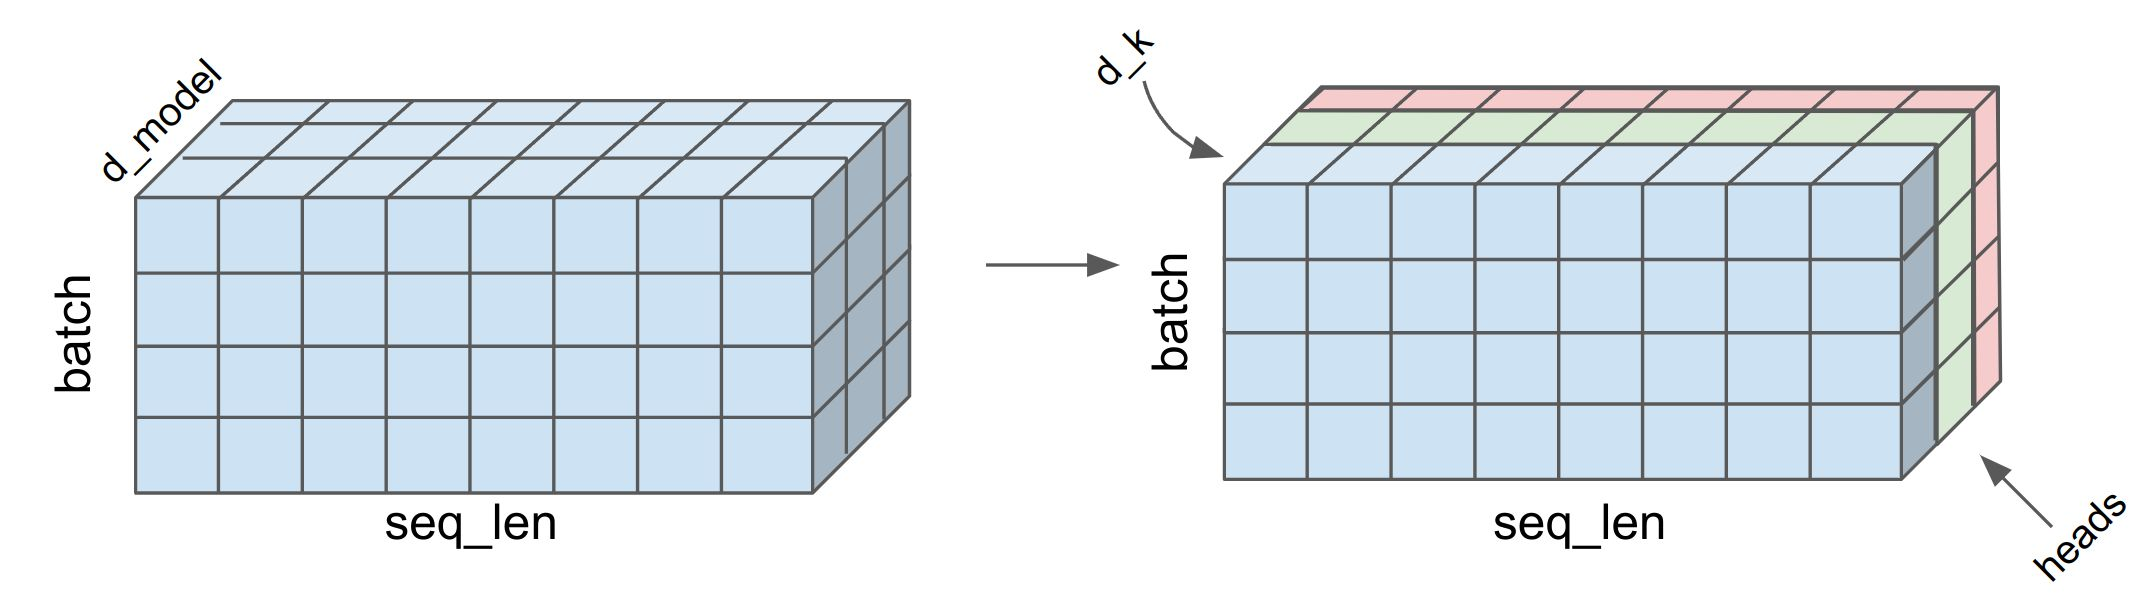

## MAsked Multi Head Seft Attention
* In the transformer model, the decoder learns from both encoder and its own history, but during training, the decoder can't access future information, crucial for predicting the next token.
* In the encoder, scores for each word are calculated based on all other words in the sentence, exemplifying forward-looking relationships. However, during decoding, when predicting the next word, such scores aren't available for words yet to be predicted, as seen when predicting "I" in the example "I LOVE PYTHON."
* To train the decoder without forward-looking information, future values are masked by setting them to 0 in the attention scores matrix. This masked self-attention allows the decoder to focus only on previously predicted words. To achieve 0, values are set to negative infinity, ensuring that after the softmax function transformation, they become 0.

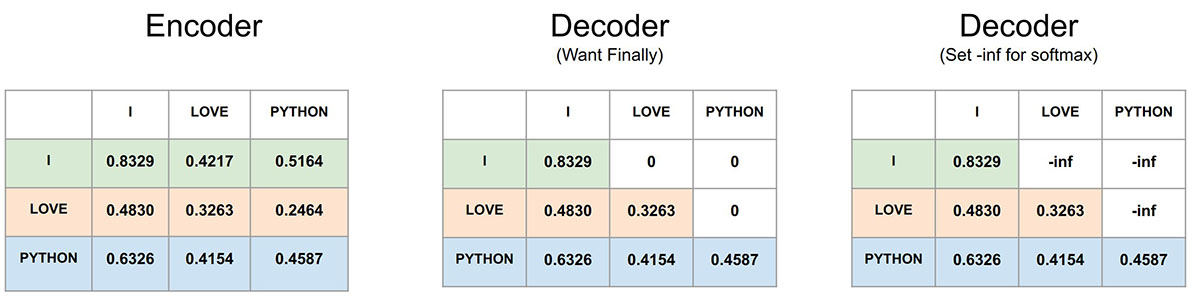

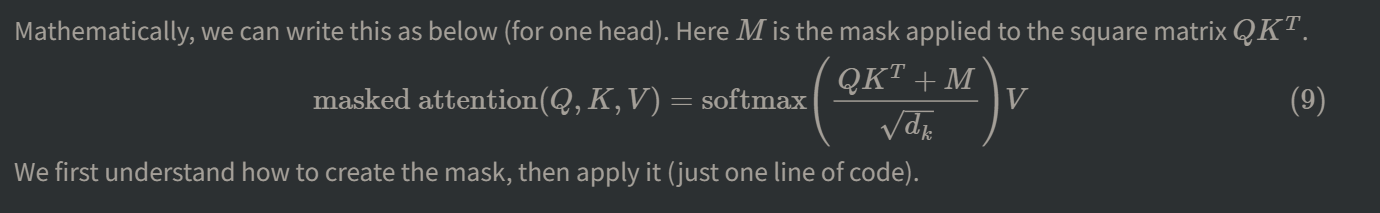

Lets see how can we do this masking - applied on top of the `qk product`

In [17]:
q = torch.rand(1, seq_len, d_model)
k = torch.rand(1, seq_len, d_model)
v = torch.rand(1, seq_len, d_model)

In [18]:
qk = q @ k.transpose(-2, -1)
print(qk.shape)

torch.Size([1, 3, 3])


In [19]:
# torch.triu() to calculate triangular matrix. Setting diagonal=1 will set the diagonal values to 0.
mask_filter = torch.triu(qk, diagonal=1).type(torch.bool)==0
print(mask_filter)

tensor([[[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]])


In order to create a mask of any seq_len, we can first a row vector of size seq_len using torch.ones(seq_len) then to apply the filter just multiply the mask. Now our upper triangular mask is ready to be used.


In [20]:
mask = torch.ones(seq_len) * mask_filter
print(mask)

tensor([[[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]])


In [21]:
# imp step 
F.softmax((qk.masked_fill(mask == 0, -1e9) / math.sqrt(d_k)), dim=-1)

tensor([[[1.0000, 0.0000, 0.0000],
         [0.6038, 0.3962, 0.0000],
         [0.3530, 0.2862, 0.3608]]])

## Masked Multi-head Self Attention Block using pytorch Module

In [22]:
class MaskedMultiHeadAttentionBlock(nn.Module):
    """
    This class is used to create the masked multi-head attention block.
    The masked multi-head attention block consists of the following layers:
    - Wq : The query weights
    - Wk : The key weights
    - Wv : The value weights
    - Wo : The output weights
    - Dropout : The dropout layer
    The forward function of the class is used to calculate the attention scores for the input query, key and value.
    The attention scores are then returned.

    Args:
    d_model : int : The dimension of the model
    heads : int : The number of heads
    dropout_rate : float : The dropout rate

    Returns:
    op : tensor : The output of the masked multi-head attention block
    """

    def __init__(self, d_model: int, heads: int, dropout_rate: float) -> None:
        super(MaskedMultiHeadAttentionBlock, self).__init__()
        self.d_model = d_model
        self.heads = heads
        # init head dim
        self.d_k = d_model // heads

        # initialize fc layers Weights for q,k,v generation
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)

        # Final Dense Layer for Condensation after application of attention
        self.Wo = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(dropout_rate)

    def multihead_attention(self, q, k, v, mask, dropout):
        # multiply query and key vector (batch, head, seq , d_k) @ (batch , head, d_k, seq) = (batch, head, seq, seq)
        d_k = q.size(-1)
        qk = q @ k.transpose(-2, -1)
        scaled_qk = qk / math.sqrt(d_k)

        # application of masking
        if mask is not None:
            print("Applying Mask to the scaled_qk")
            scaled_qk.masked_fill_(mask == 0, -1e9)


        # softmax scoring with upper triangular masking if applicable
        scores = F.softmax(scaled_qk, dim=-1)
        # print(scores)

        if dropout is not None:
            print("Applying Dropout to the softmax scores")
            scores = dropout(scores)
            # print(scores)

        # (batch, head, seq_len, seq_len) @ # (batch, head, seq_len, d_model) = (batch, head, seq_len, d_model)
        final_matrix = scores @ v
        # print(final_matrix)

        return final_matrix

    def forward(self, q, k, v, mask=None):
        # fisrt we calculate the query, key and value vectors from fc layers then convert them into groups and then calculate the attention scores and concat back
        query = self.Wq(q)
        key = self.Wk(k)
        value = self.Wv(v)

        # convert (batch, seq, d_model) -> (batch, seq, head, d_k) -> (batch, head, seq, d_k)
        query = query.view(
            query.shape[0], query.shape[1], self.heads, self.d_k
        ).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.heads, self.d_k).transpose(1, 2)
        value = value.view(
            value.shape[0], value.shape[1], self.heads, self.d_k
        ).transpose(1, 2)

        attention_scores = self.multihead_attention(
            query, key, value, mask, self.dropout
        )

        # convert (batch, head, seq, d_k) -> (batch, seq, head, d_k) -> (batch, seq, d_model)

        x = (
            attention_scores.transpose(1, 2)
            .contiguous()
            .view(attention_scores.shape[0], -1, self.d_k * self.heads)
        )
        # print(x.shape)

        op = self.Wo(x)

        return op

In [23]:
mm_attention = MaskedMultiHeadAttentionBlock(
    d_model=d_model, heads=heads, dropout_rate=0.1
)

In [24]:
# inputs
x = torch.rand(1, seq_len, d_model)

mask_filter = (
    torch.triu(torch.ones(1, seq_len, seq_len), diagonal=1).type(torch.bool) == 0
)
mask = torch.ones(seq_len) * mask_filter

In [25]:
attention_output = mm_attention(k=x, q=x, v=x, mask=mask)

Applying Mask to the scaled_qk
Applying Dropout to the softmax scores


In [26]:
print(attention_output.shape)
print(attention_output)

torch.Size([1, 3, 10])
tensor([[[-0.1603, -0.1611, -0.0948,  0.0224, -0.1811, -0.0097, -0.3542,
           0.2893,  0.0005, -0.1768],
         [-0.2647, -0.3191,  0.0485, -0.3029, -0.1707, -0.0681, -0.3224,
           0.1650,  0.1288,  0.2981],
         [-0.2791, -0.2879, -0.1221, -0.0956, -0.2909,  0.0259, -0.3942,
           0.2299,  0.0931,  0.1150]]], grad_fn=<UnsafeViewBackward0>)


## FEED FORWARD BLOCK
* There are two linear transformations including bias and after the first linear transformation relu has been used as activation function
* FF(x) = Relu(XW1 + b1)W2 + b2

In [27]:
class FeedForwardBlock(nn.Module):
    """
    This class is used to create the feed forward block.
    The feed forward block consists of the following layers:
    - Linear1 : The first linear layer
    - Dropout : The dropout layer
    - Linear2 : The second linear layer
    The forward function of the class is used to calculate the output of the feed forward block.
    The output of the feed forward block is then returned.

    Args:
    d_model : int : The dimension of the model
    d_ff : int : The dimension of the feed forward network
    dropout_rate : float : The dropout rate

    Returns:
    out : tensor : The output of the feed forward block
    """

    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        super(FeedForwardBlock, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = self.dropout(out)
        out = self.linear2(out)

        return out

In [28]:
input_x = torch.rand(1, seq_len, d_model)
ff_block = FeedForwardBlock(d_model=d_model, d_ff=2048, dropout_rate=0.1) # 2048 is the hidden layer size
output = ff_block(input_x)
print(output.shape)

torch.Size([1, 3, 10])


## Add and Norm is the layer normalization and skip connection .In each encoder the Add & Norm is used 2 times and in decoder 3 times.

### Layer Normalization
* We'll implement Layer Normalization and Skip Connection separately, with Layer Normalization ensuring 0 mean and unit variance to reduce covariance shift and speed up convergence.

In [29]:
class LayerNormalizationBlock(nn.Module):
    """
    This class is used to create the layer normalization block.
    The layer normalization block consists of the following layers:
    - LayerNorm : The layer normalization layer
    The forward function of the class is used to calculate the output of the layer normalization block.
    The output of the layer normalization block is then returned.

    Args:
    features : int : The number of features
    eps : float : The epsilon value

    Returns:
    x : tensor : The output of the layer normalization block
    """

    def __init__(self, features: int = d_model, eps: float = 1e-6):
        super(LayerNormalizationBlock, self).__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))

    def forward(self, x):
        # the summary metrics like mean and variance are calculated across the last dimension ie embedding dimension
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        # normalization
        norm = (x - mean) / (std + self.eps)
        # scale and shift
        op = self.alpha * norm + self.bias
        return op

In [30]:
input_x = torch.rand(2, seq_len, d_model)
ln_block = LayerNormalizationBlock()
output = ln_block(input_x)
print(output.shape)

torch.Size([2, 3, 10])


### SKIP Connection
* Post Layer Normalization, that is Layer Normalization after Skip Connection. However recent studies shows that using Pre-Layer Normalization may be more effective than Post Layer Normalization

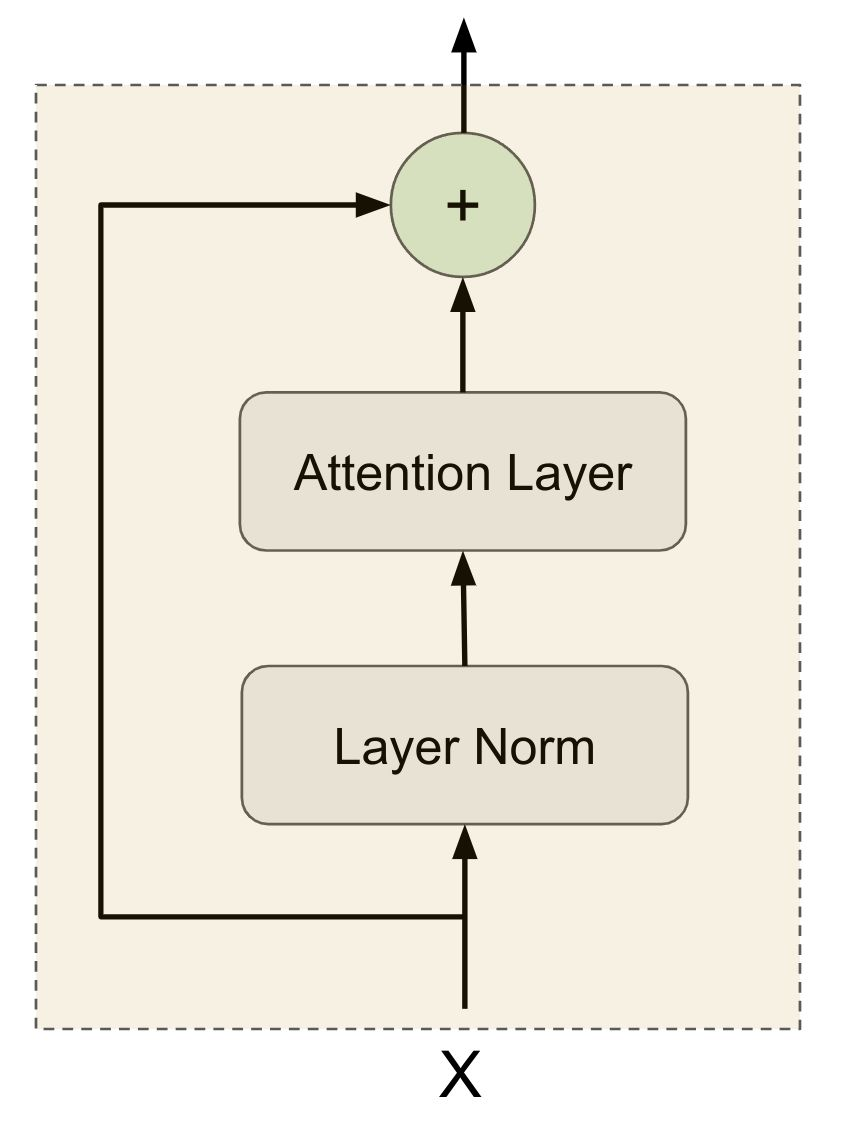

* It takes x and the prev_layer (In this case MaskedMultiHeadSelfAttentionBlock) as input.
* Then first passes x through LayerNormalizationBlock.
* Then the output of LayerNormalizationBlock goes through whatever prev_layer has been passed (could be either FeedForwardBlock or MaskedMultiHeadSelfAttentionBlock)
* Then adds with previous input x after using a dropout

In [31]:
class SkipConnectionBlock(nn.Module):
    """
    This class is used to create the skip connection block.
    The skip connection block consists of the following layers:
    - Dropout : The dropout layer
    - LayerNorm : The layer normalization layer
    The forward function of the class is used to calculate the output of the skip connection block.
    The output of the skip connection block is then returned.

    Args:
    features : int : The number of features
    dropout_rate : float : The dropout rate

    Returns:
    op : tensor : The output of the skip connection block
    """

    def __init__(self, features: int, dropout_rate: float):
        super(SkipConnectionBlock, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layernorm = LayerNormalizationBlock(features)

    def forward(self, x, sublayer):
        # sublayer can be  FeedForwardBlock or MaskedMultiHeadSelfAttentionBlock
        op = x + self.dropout(sublayer(self.layernorm(x)))
        return op

## Encoder Block  + Encoder Sequence
* it takes the FeedForwardBlock and MaskedMultiHeadSelfAttentionBlock as input. Then initializes two SkipConnectionBlock in one block 
* we can have N no of blocks using module list and forward function to iterate over the blocks

* Each encoder block will have 2 sublayer connection , with sub layer havng masked multihead attention as main layer along with layernorm and skip and second sub layer having FFN at the heart along with layernorm and skip connection
* In the forward method, we access the SkipConnectionBlock instances. We take input `x` (from PositionalEncodingBlock or another EncoderBlock) and pass it through MaskedMultiHeadSelfAttentionBlock. To pass 4 inputs, we use a lambda function to invoke the forward() method of MaskedMultiHeadSelfAttentionBlock.
* Then we take the output from the MaskedMultiHeadSelfAttentionBlock and invoke the forward() method of the FeedForwardBlock.

** From here onwarads we will be creating the Encoder and Decoder Blocks which will be a bit different as compared to the original blog as we have rectified a few mistakes in the original blog.**

In [32]:
N = 3

In [33]:
def clones(module, N):
    "Produce N identical layers of pytorch modules as a list"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [34]:
class EncoderBlock(nn.Module):
    """
    This class is used to create the encoder block.
    The encoder block consists of the following layers:
    - attention_block : The masked multi-head attention block
    - feed_forward_block : The feed forward block
    - skipconnection_block : The skip connection block
    The forward function of the class is used to calculate the output of the encoder block.
    The output of the encoder block is then returned.

    Args:
    features : int : The number of features
    attention_block : nn.Module : The masked multi-head attention block
    feed_forward_block : nn.Module : The feed forward block
    dropout_rate : float : The dropout rate

    Returns:
    x : tensor : The output of the encoder block
    """

    def __init__(
        self,
        features: int,
        attention_block: MaskedMultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout_rate: float,
    ):
        super(EncoderBlock, self).__init__()
        self.features = features
        self.attention_block = attention_block
        self.feed_forward_block = feed_forward_block
        self.skipconnection_block = clones(
            SkipConnectionBlock(features, dropout_rate), 2
        )  # always 2 skip connections

    def forward(self, x, mask):
        x = self.skipconnection_block[0](
            x, lambda x: self.attention_block(k=x, q=x, v=x, mask=mask)
        )
        x = self.skipconnection_block[1](x, self.feed_forward_block)
        return x

If we have N EndoderBlock stacked then the EncoderSequenceBlock is going to invoke them one after another.

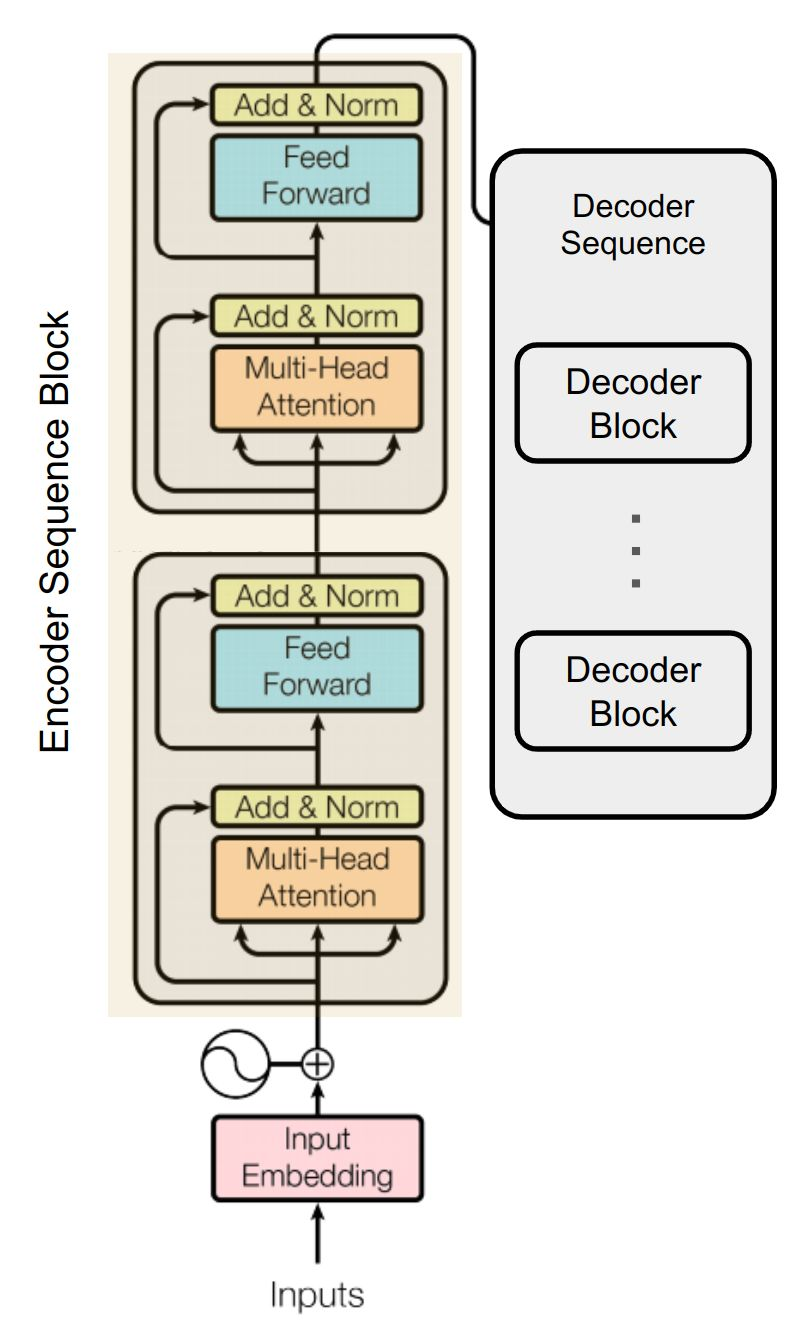

* The EncoderSequenceBlock uses a ModuleList of EncoderBlocks and adds a Post Layer Normalization step after their execution, deviating from the paper's Post-Layer Normalization approach.

In [35]:
# Part of Actual Transformer Model
class EncoderSequenceBlock(nn.Module):
    """
    This class is used to create the encoder sequence block.
    The encoder sequence block consists of the following layers:
    - encoder_blocks : The encoder blocks
    - layernorm : The layer normalization block
    The forward function of the class is used to calculate the output of the encoder sequence block.

    Args:
    encoder_block : nn.Module : The encoder block

    Returns:
    x : tensor : The output of the encoder sequence block
    """

    def __init__(self, encoder_block: EncoderBlock, N: int):
        super(EncoderSequenceBlock, self).__init__()
        self.encoder_blocks = clones(encoder_block, N)
        self.layernorm = LayerNormalizationBlock(encoder_block.features)

    def forward(self, x, mask):
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)

        return self.layernorm(x)

## Decoder Block + Decoder Sequence

* The DecoderBlock has three Skip Connections. It also takes 3 blocks as input arguments. Two of them are MaskedMultiHeadSelfAttentionBlock and one FeedForwardBlock. 
* The 2nd MaskedMultiHeadSelfAttentionBlock is receiving the output from the last EncoderBlock in the EncoderSequenceBlock, hence its called as cross attention
* how the encoder and decoder is connected and sharing information. Every DecoderBlock receives the same last_encoder_block_output as both k and v
  

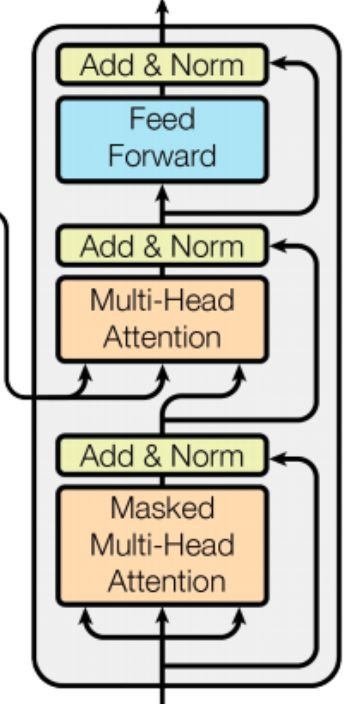

In [36]:
class DecoderBlock(nn.Module):
    """
    This class is used to create the decoder block.
    The decoder block consists of the following layers:
    - attention_block : The masked multi-head attention block
    - cross_attention_block : The masked multi-head attention block
    - feed_forward_block : The feed forward block
    - skipconnection_block : The skip connection block
    The forward function of the class is used to calculate the output of the decoder block.
    The output of the decoder block is then returned.

    Args:
    features : int : The number of features
    attention_block : nn.Module : The masked multi-head attention block
    cross_attention_block : nn.Module : The masked multi-head attention block
    feed_forward_block : nn.Module : The feed forward block
    dropout_rate : float : The dropout rate

    Returns:
    x : tensor : The output of the decoder block
    """

    def __init__(
        self,
        features: int,
        attention_block: MaskedMultiHeadAttentionBlock,
        cross_attention_block: MaskedMultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout_rate: float,
    ):
        super(DecoderBlock, self).__init__()
        self.features = features
        self.attention_block = attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.skip_connection_block = clones(
            SkipConnectionBlock(features, dropout_rate), 3
        )

    def forward(self, x, last_encoder_output, src_mask, tgt_mask):
        # atttention block takes the last decoder op
        x = self.skip_connection_block[0](
            x, lambda x: self.attention_block(k=x, q=x, v=x, mask=tgt_mask)
        )
        # cross attention block takes the op from entire encoder layer
        x = self.skip_connection_block[1](
            x,
            lambda x: self.cross_attention_block(
                q=x, k=last_encoder_output, v=last_encoder_output, mask=src_mask
            ),
        )
        # feed forward block
        x = self.skip_connection_block[2](x, self.feed_forward_block)
        return x

In [37]:
# Part of Actual Transformer Model
class DecoderSequenceBlock(nn.Module):
    """
    This class is used to create the decoder sequence block.
    The decoder sequence block consists of the following layers:
    - decoder_blocks : The decoder blocks
    - layernorm : The layer normalization block
    The forward function of the class is used to calculate the output of the decoder sequence block.

    Args:
    decoder_block : nn.Module : The decoder block

    Returns:
    x : tensor : The output of the decoder sequence block
    """

    def __init__(self, decoder_block: DecoderBlock, N: int):
        super(DecoderSequenceBlock, self).__init__()
        self.decoder_blocks = clones(decoder_block, N)
        self.layernorm = LayerNormalizationBlock(decoder_block.features)

    def forward(self, x, last_encoder_output, src_mask, tgt_mask):
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, last_encoder_output, src_mask, tgt_mask)

        return self.layernorm(x)

## Linear Block for probablity calculation

In [38]:
# part of actual transformer model
class LinearSoftmaxBlock(nn.Module):
    """
    This class is used to create the linear softmax block.
    The linear softmax block consists of the following layers:
    - linear : The linear layer
    The forward function of the class is used to calculate the output of the linear softmax block.
    The output of the linear softmax block is then returned.

    Args:
    d_model : int : The dimension of the model
    vocab_size : int : The size of the vocabulary

    Returns:
    op : tensor : The output of the linear softmax block
    """

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Softmax using the last dimension
        # [batch, seq_len, d_model] -> [batch, seq_len]
        return torch.log_softmax(self.linear(x), dim=-1)

## Final Transformer Block

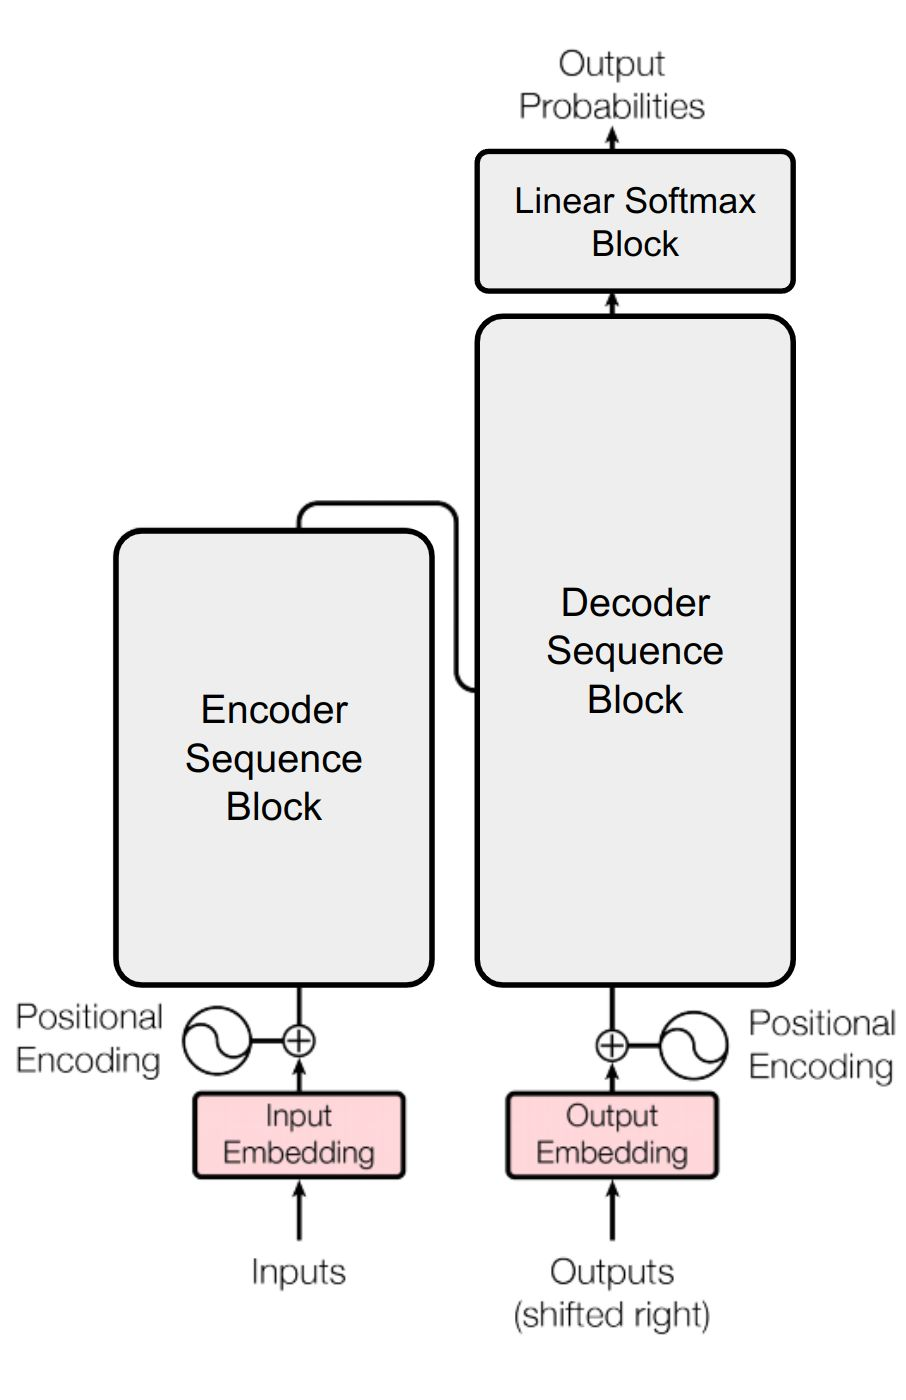

In [39]:
class Transformer(nn.Module):
    """
    This class is used to create the transformer model.
    The transformer model consists of the following layers:
    - input_embedding_block : The input embedding block
    - output_embedding_block : The output embedding block
    - input_pos_block : The positional encoding block for the input sequence
    - output_pos_block : The positional encoding block for the output sequence
    - encoder_seq_block : The encoder sequence block
    - decoder_seq_block : The decoder sequence block
    - linear_softmax_block : The linear softmax block
    The forward function of the class is used to calculate the output of the transformer model.

    Args:
    input_embedding_block : nn.Module : The input embedding block
    output_embedding_block : nn.Module : The output embedding block
    input_pos_block : nn.Module : The positional encoding block for the input sequence
    output_pos_block : nn.Module : The positional encoding block for the output sequence
    encoder_seq_block : nn.Module : The encoder sequence block
    decoder_seq_block : nn.Module : The decoder sequence block
    linear_sotfmax_block : nn.Module : The linear softmax block

    Returns:
    op : tensor : The output of the transformer model
    """

    def __init__(
        self,
        input_embedding_block: IOEmbedding,
        output_embedding_block: IOEmbedding,
        input_pos_block: PositionalEncodingBlock,
        output_pos_block: PositionalEncodingBlock,
        encoder_seq_block: EncoderSequenceBlock,
        decoder_seq_block: DecoderSequenceBlock,
        linear_sotfmax_block: LinearSoftmaxBlock,
    ):
        super(Transformer, self).__init__()
        self.input_embedding_block = input_embedding_block
        self.output_embedding_block = output_embedding_block
        self.input_pos_block = input_pos_block
        self.output_pos_block = output_pos_block
        self.encoder_seq_block = encoder_seq_block
        self.decoder_seq_block = decoder_seq_block
        self.linear_sotfmax_block = linear_sotfmax_block

    def encode(self, src, src_mask):
        src = self.input_embedding_block(src)
        src = self.input_pos_block(src)
        return self.encoder_seq_block(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.output_embedding_block(tgt)
        tgt = self.output_pos_block(tgt)
        return self.decoder_seq_block(tgt, encoder_output, src_mask, tgt_mask)

    def linear_projection(self, x):
        return self.linear_sotfmax_block(x)

Create the model and test it on inference data

In [40]:
d_model = 512
heads = 8
N = 6
d_ff = 2048
dropout_rate = 0.1
dim = 11

In [60]:
def build_transformer(d_model, heads, N, d_ff, dropout_rate, dim):
    """
    This function is used to build the transformer model.
    The transformer model consists of the following layers:
    - masked_multi_head_attention_block : The masked multi-head attention block
    - feed_forward_block : The feed forward block
    - input_embedding_block : The input embedding block
    - output_embedding_block : The output embedding block
    - input_pos_block : The positional encoding block for the input sequence
    - output_pos_block : The positional encoding block for the output sequence
    - encoder_block : The encoder block
    - encoder_seq_block : The encoder sequence block
    - decoder_block : The decoder block
    - decoder_seq_block : The decoder sequence block
    - linear_block : The linear softmax block
    The transformer model is then returned.

    Args:
    d_model : int : The dimension of the model
    heads : int : The number of heads
    N : int : The number of encoder and decoder blocks
    d_ff : int : The dimension of the feed forward network
    dropout_rate : float : The dropout rate
    dim : int : The size of the vocabulary

    Returns:
    model : nn.Module : The transformer model
    """
    c = copy.deepcopy
    # masked multi-head attention block
    attention_block = MaskedMultiHeadAttentionBlock(
        d_model=d_model, heads=heads, dropout_rate=dropout_rate
    )
    print(attention_block)
    # feed forward block
    feed_forward_block = FeedForwardBlock(
        d_model=d_model, d_ff=d_ff, dropout_rate=dropout_rate
    )
    print(feed_forward_block)
    # input and output embedding block
    input_embedding_block = IOEmbedding(d_model=d_model, vocab_size=dim)
    output_embedding_block = IOEmbedding(d_model=d_model, vocab_size=dim)
    # positional encoding block
    input_pos_block = PositionalEncodingBlock(d_model=d_model, seq_len=dim)
    output_pos_block = PositionalEncodingBlock(d_model=d_model, seq_len=dim)

    # encoder block
    encoder_block = EncoderBlock(
        d_model, c(attention_block), c(feed_forward_block), dropout_rate
    )
    print(encoder_block)
    # encoder seq block
    encoder_seq_block = EncoderSequenceBlock(encoder_block, N)
    print(encoder_seq_block)

    # decoder block
    decoder_block = DecoderBlock(
        d_model,
        c(attention_block),
        c(attention_block),
        c(feed_forward_block),
        dropout_rate,
    )
    print(decoder_block)

    # decoder seq block
    decoder_seq_block = DecoderSequenceBlock(decoder_block, N)
    print(decoder_seq_block)

    # linear softmax block
    linear_block = LinearSoftmaxBlock(d_model=d_model, vocab_size=dim)

    # transformer model
    model = Transformer(
        input_embedding_block,
        output_embedding_block,
        input_pos_block,
        output_pos_block,
        encoder_seq_block,
        decoder_seq_block,
        linear_block,
    )

    return model

In [63]:
transformer_model = build_transformer(d_model, heads, N, d_ff, dropout_rate, dim)
# print(transformer_model)

MaskedMultiHeadAttentionBlock(
  (Wq): Linear(in_features=512, out_features=512, bias=False)
  (Wk): Linear(in_features=512, out_features=512, bias=False)
  (Wv): Linear(in_features=512, out_features=512, bias=False)
  (Wo): Linear(in_features=512, out_features=512, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)
FeedForwardBlock(
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
)
EncoderBlock(
  (attention_block): MaskedMultiHeadAttentionBlock(
    (Wq): Linear(in_features=512, out_features=512, bias=False)
    (Wk): Linear(in_features=512, out_features=512, bias=False)
    (Wv): Linear(in_features=512, out_features=512, bias=False)
    (Wo): Linear(in_features=512, out_features=512, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward_block): FeedForwardBlock(
    (linear1): Linear(in_features=512, out_features=2048, bias=Tru

DecoderBlock(
  (attention_block): MaskedMultiHeadAttentionBlock(
    (Wq): Linear(in_features=512, out_features=512, bias=False)
    (Wk): Linear(in_features=512, out_features=512, bias=False)
    (Wv): Linear(in_features=512, out_features=512, bias=False)
    (Wo): Linear(in_features=512, out_features=512, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (cross_attention_block): MaskedMultiHeadAttentionBlock(
    (Wq): Linear(in_features=512, out_features=512, bias=False)
    (Wk): Linear(in_features=512, out_features=512, bias=False)
    (Wv): Linear(in_features=512, out_features=512, bias=False)
    (Wo): Linear(in_features=512, out_features=512, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward_block): FeedForwardBlock(
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (skip_connection_block): ModuleList

In [64]:
transformer_model.eval()

Transformer(
  (input_embedding_block): IOEmbedding(
    (embedding_layer): Embedding(11, 512)
  )
  (output_embedding_block): IOEmbedding(
    (embedding_layer): Embedding(11, 512)
  )
  (input_pos_block): PositionalEncodingBlock()
  (output_pos_block): PositionalEncodingBlock()
  (encoder_seq_block): EncoderSequenceBlock(
    (encoder_blocks): ModuleList(
      (0-5): 6 x EncoderBlock(
        (attention_block): MaskedMultiHeadAttentionBlock(
          (Wq): Linear(in_features=512, out_features=512, bias=False)
          (Wk): Linear(in_features=512, out_features=512, bias=False)
          (Wv): Linear(in_features=512, out_features=512, bias=False)
          (Wo): Linear(in_features=512, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_featu

In [65]:
src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
src_mask = torch.ones(1, 1, 10)

print(src.shape)
print(src_mask.shape)

torch.Size([1, 10])
torch.Size([1, 1, 10])


In [66]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

In [54]:
# subsequent_mask(5).type_as(src.data)

In [67]:
memory = transformer_model.encode(src, src_mask)
print(memory.shape)
print(memory[0][0].shape)

Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
torch.Size([1, 10, 512])
torch.Size([512])


In [68]:
ys = torch.zeros(1, 1).type_as(src)
print(ys)

tensor([[0]])


In [69]:
# subsequent_mask(ys.size(1)).type_as(src.data).shape

In [70]:
for i in range(9):

    # output of the decoder
    out = transformer_model.decode(
        memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )
    print(out.shape)
    # output of the linear layer in logits
    prob = transformer_model.linear_projection(out[:, -1])
    print(prob.shape)
    # get the next word by argmax
    next_word = torch.argmax(prob, dim=1)
    print(next_word)
    # 0 dim next word
    next_word = next_word.data[0]
    # concat the next word to the output
    ys = torch.cat([ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1)

Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
torch.Size([1, 1, 512])
torch.Size([1, 11])
tensor([9])
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
App

Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
torch.Size([1, 2, 512])
torch.Size([1, 11])
tensor([5])
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
Applying Dropout to the softmax scores
Applying Mask to the scaled_qk
App

In [71]:
ys

tensor([[0, 9, 5, 1, 0, 9, 5, 1, 0, 9]])